## PRÉ-PROCESSAMENTO DOS DADOS

Sabemos que cada exemplo do dataset é composto por 784 pixels e um label que representa o verdadeiro valor dígito (```y=label```). Temos como requisito a utilização dos modelos lineares de aprendizagem de máquina (perceptron, regressão linear e regressão logística). 

O pré-processamento que é realizado para a redução da dimensionalidade da amostra é o de sintetizar os dados das imagens em duas informações de entrada: intensidade e simetria da imagem de acordo com os pixels (na amostra os pixels estão em uma escala de cinza que vai de ```[0,255]```, onde quão maior é o valor mais escuro é o pixel).

In [1]:
# Importando as bibliotecas pertinentes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Importando as implementações dos modelos lineares de AM

from pocketpla import PocketPLA
from linregression import LinearRegression
from logregression import LogisticRegression

In [3]:
# Leitura dos dados

filename = "data/train.csv"

pixels = np.loadtxt(filename, dtype='int64', skiprows=1, delimiter=',', usecols=range(2,786))
labels = np.loadtxt(filename, dtype='int64', skiprows=1, delimiter=',', usecols=1)

pixels, labels, pixels.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([1, 1, 0, ..., 1, 7, 9]),
 (27773, 784))

### Intensidade:

Dada pela equação: $$I= \frac{\sum_{n=0}^{783}pixel_i}{255}$$

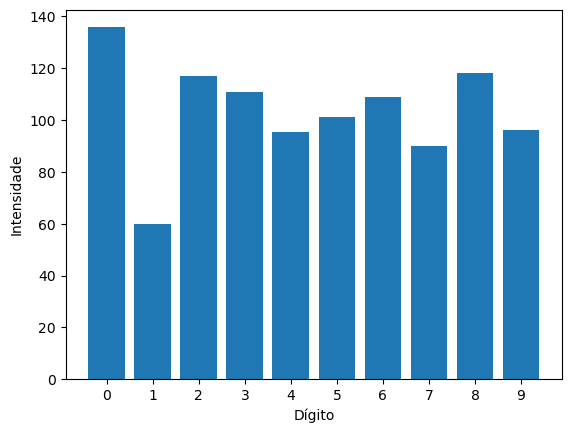

In [4]:
I = np.array([np.sum(i)/255
              for i in pixels])

I_d = []
for i in range(10):
    I_d.append((i, np.mean(I[labels == i])))

plt.bar(*zip(*I_d))

plt.xlabel('Dígito')
plt.ylabel('Intensidade')
plt.xticks(np.arange(10))
plt.show()

### Simetria:

A simetria vertical é dada pela equação: $$S_v= \frac{\sum_{i=0}^{27}\sum_{j=0}^{13}||pixel_{i,j} - pixel_{i,27-j}||}{255}$$

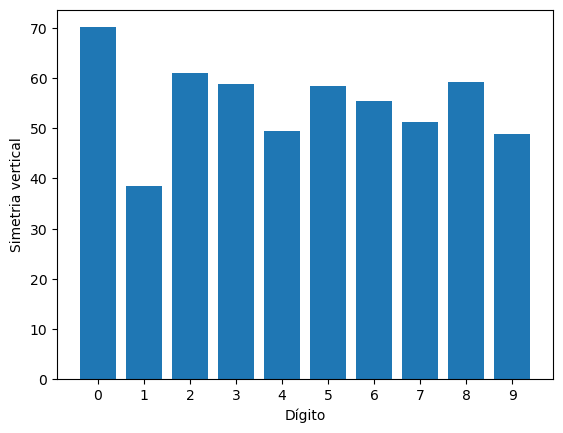

In [5]:
S_v = np.zeros(pixels.shape[0])

for p in range(pixels.shape[0]):
    soma = 0
    for i in range(28):
        soma += np.sum(abs(pixels[p][i*28:i*28+14] - pixels[p][i*28+27:i*28+13:-1]))

    S_v[p] = soma/255
    
S_vd = []
for i in range(10):
    S_vd.append((i, np.mean(S_v[labels == i])))

plt.bar(*zip(*S_vd))

plt.xlabel('Dígito')
plt.ylabel('Simetria vertical')
plt.xticks(np.arange(10))
plt.show()

A simetria horizontal é dada pela equação: $$S_v= \frac{\sum_{i=0}^{13}\sum_{j=0}^{27}||pixel_{i,j} - pixel_{27-i,j}||}{255}$$

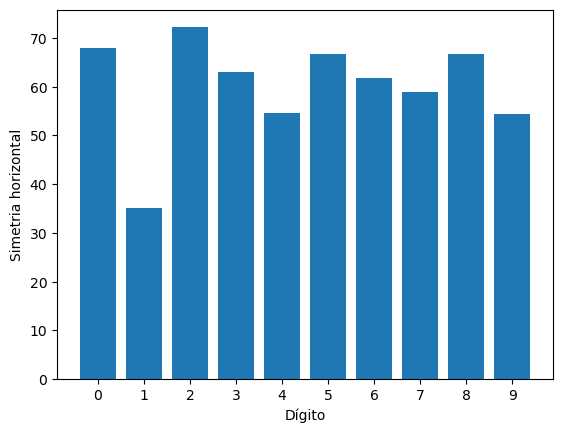

In [6]:
S_h = np.zeros(pixels.shape[0])

for p in range(pixels.shape[0]):
    soma = 0
    for i in range(14):
        soma += np.sum(abs(pixels[p][i*28:(i+1)*28] - pixels[p][(27-i)*28:(28-i)*28]))

    S_h[p] = soma/255

S_vh = []
for i in range(10):
    S_vh.append((i, np.mean(S_h[labels == i])))

plt.bar(*zip(*S_vh))

plt.xlabel('Dígito')
plt.ylabel('Simetria horizontal')
plt.xticks(np.arange(10))
plt.show()

Obtendo a simetria por uma eixo diagonal:

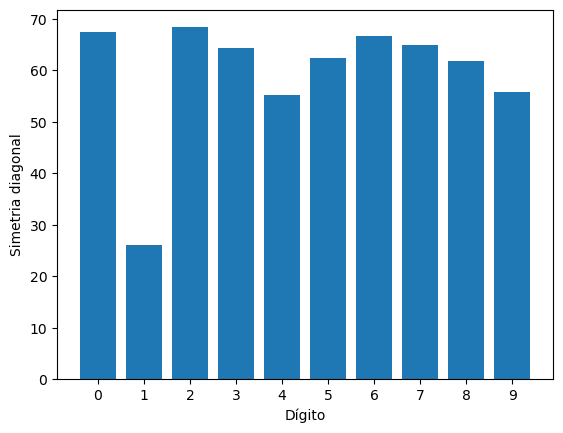

In [7]:
S_d = np.zeros(pixels.shape[0])

for p in range(pixels.shape[0]):
    S_d[p] = np.sum(abs(pixels[p][0:392] - pixels[p][-1:391:-1]))/255

S_dd = []
for i in range(10):
    S_dd.append((i, np.mean(S_d[labels == i])))

plt.bar(*zip(*S_dd))

plt.xlabel('Dígito')
plt.ylabel('Simetria diagonal')
plt.xticks(np.arange(10))
plt.show()

Podemos obter a simetria completa da imagem pela soma das simetrias vertical e horizontal. Inicialmente, utilizaremos como medida de simetria apenas a simetria horizontal:

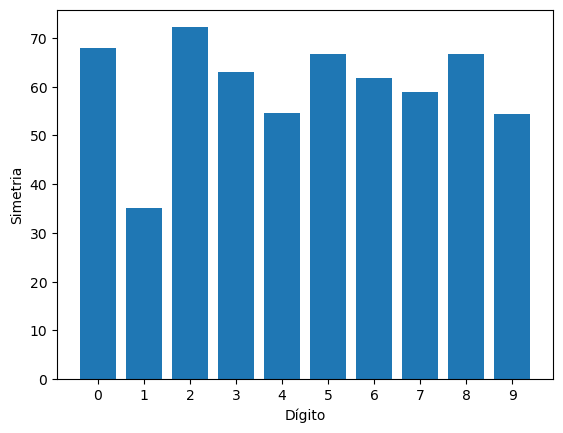

In [8]:
S = S_h

Sd = []
for i in range(10):
    Sd.append((i, np.mean(S[labels == i])))

plt.bar(*zip(*Sd))

plt.xlabel('Dígito')
plt.ylabel('Simetria')
plt.xticks(np.arange(10))
plt.show()

Obtendo o novo dataset composto pela intensidade, simetria e labels:

In [9]:
new_data = np.column_stack((I, S, labels))

new_data

array([[ 65.29019608,  55.36862745,   1.        ],
       [ 52.64705882,   7.10980392,   1.        ],
       [ 90.43529412,  51.31372549,   0.        ],
       ...,
       [ 52.60784314,  19.62745098,   1.        ],
       [123.54509804,  80.03921569,   7.        ],
       [ 71.28627451,  45.19215686,   9.        ]])

In [10]:
new_data_3dim = np.column_stack((I, S_v, S_h, labels))

new_data_3dim

array([[ 65.29019608,  55.36078431,  55.36862745,   1.        ],
       [ 52.64705882,   9.47843137,   7.10980392,   1.        ],
       [ 90.43529412,  52.23137255,  51.31372549,   0.        ],
       ...,
       [ 52.60784314,  30.3254902 ,  19.62745098,   1.        ],
       [123.54509804,  58.98823529,  80.03921569,   7.        ],
       [ 71.28627451,  51.36470588,  45.19215686,   9.        ]])

Realizando a mesma transformação para os dados de teste:

In [11]:
# Leitura dos dados

filename_test = "data/test.csv"

pixels_test = np.loadtxt(filename_test, dtype='int64', skiprows=1, delimiter=',', usecols=range(2,786))
labels_test = np.loadtxt(filename_test, dtype='int64', skiprows=1, delimiter=',', usecols=1)

I = [np.sum(i)/255
     for i in pixels_test]

S_v = np.zeros(pixels_test.shape[0])
for p in range(pixels_test.shape[0]):
    soma = 0
    for i in range(28):
        soma += np.sum(abs(pixels_test[p][i*28:i*28+14] - pixels_test[p][i*28+27:i*28+13:-1]))

    S_v[p] = soma/2550.0
    
S_h = np.zeros(pixels_test.shape[0])
for p in range(pixels_test.shape[0]):
    soma = 0
    for i in range(14):
        soma += np.sum(abs(pixels_test[p][i*28:(i+1)*28] - pixels_test[p][(27-i)*28:(28-i)*28]))

    S_h[p] = soma/255

S = S_h

new_data_test = np.column_stack((I, S, labels_test))
new_data_3dim_test = np.column_stack((I, S_v, S_h, labels_test))

Construindo novos arquivos de treino e teste ```train_redu.csv``` e ```test_redu.csv``` contendo as colunas: label, intensidade e simetria.

In [12]:
pd.DataFrame({'label' : map(int, new_data[:, 2]),
              'itensidade' : new_data[:, 0],
              'simetria' : new_data[:, 1]}).to_csv('train_redu.csv', index=False)

pd.DataFrame({'label' : map(int, new_data_test[:, 2]),
              'itensidade' : new_data_test[:, 0],
              'simetria' : new_data_test[:, 1]}).to_csv('test_redu.csv', index=False)

## ANÁLISE DO PRÉ-PROCESSAMENTO

Agora temos os dados em  $\mathbb{R}²$ que podem ser separados pelo conjunto de hipótese dos modelos lineares, agora vamos verificar se é possível realizar a distinção gráfica dos digitos tomados 2 a 2.

In [13]:
# Declarando funções auxiliares

# Escolher apenas 2 labels distintos do dataset
def select_digits(x, y, data):
    return np.vstack((data[data[:, 2] == x],
                      data[data[:, 2] == y]))

def cat_diff(x, y, data):
    return data[data[:, 2] == x].copy(), data[data[:, 2] == y].copy()

def plot_2digits(x, y):
    plt.grid(alpha= 0.2)
    
    plt.scatter(x[:,0], x[:,1], c='blue', label=str(int(x[0][2])))
    plt.scatter(y[:,0], y[:,1], c='red', alpha=0.4, marker='x', label=str(int(y[0][2])))
    
    plt.title(f'Comparação {int(x[0][2])}x{int(y[0][2])}')
    plt.xlabel('Intensidade')
    plt.ylabel('Assimetria')
    
    plt.legend()

Verificando para os dígitos 1 e 5:

In [14]:
dataset_1x5 = select_digits(1, 5, new_data)

In [15]:
dataset_1x5

array([[ 65.29019608,  55.36862745,   1.        ],
       [ 52.64705882,   7.10980392,   1.        ],
       [ 48.41176471,  24.10588235,   1.        ],
       ...,
       [146.5254902 ,  73.58431373,   5.        ],
       [113.34901961,  69.78039216,   5.        ],
       [121.03529412,  69.82745098,   5.        ]])

In [16]:
data_1, data_5 = cat_diff(1, 5, dataset_1x5)

In [17]:
# Para verificar se houve distinção entre o 5 e o 1 vamos obter os valores centrais

print(f'Média da Intensidade do dígito 1: {np.mean(data_1[:, 0])}, Média da Simetria do dígito 1: {np.mean(data_1[:, 1])}')
print(f'Média da Intensidade do digito 5: {np.mean(data_5[:, 0])}, Média da Simetria do dígito 5: {np.mean(data_5[:, 1])}')

Média da Intensidade do dígito 1: 59.72835060513433, Média da Simetria do dígito 1: 35.113998856830435
Média da Intensidade do digito 5: 101.13182723514335, Média da Simetria do dígito 5: 66.6828385745233


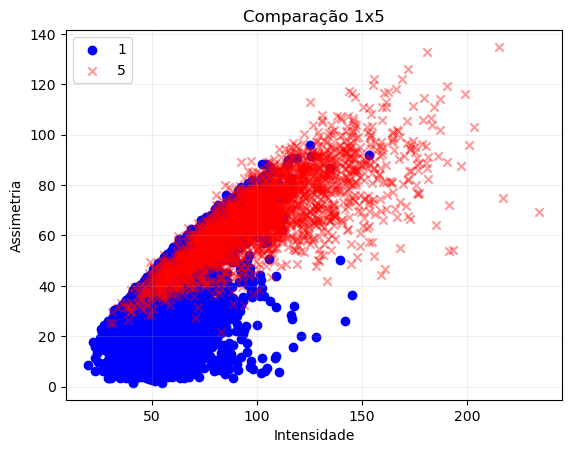

In [18]:
plot_2digits(data_1, data_5)

Verificando para vários dígitos 2 a 2:

In [19]:
digits = [new_data[new_data[:, 2] == i]
          for i in range(10)]

digits[0]

array([[ 90.43529412,  51.31372549,   0.        ],
       [130.26666667,  90.87058824,   0.        ],
       [145.43529412,  70.25098039,   0.        ],
       ...,
       [117.32156863,  78.34117647,   0.        ],
       [131.17647059,  61.73333333,   0.        ],
       [114.94117647,  62.94901961,   0.        ]])

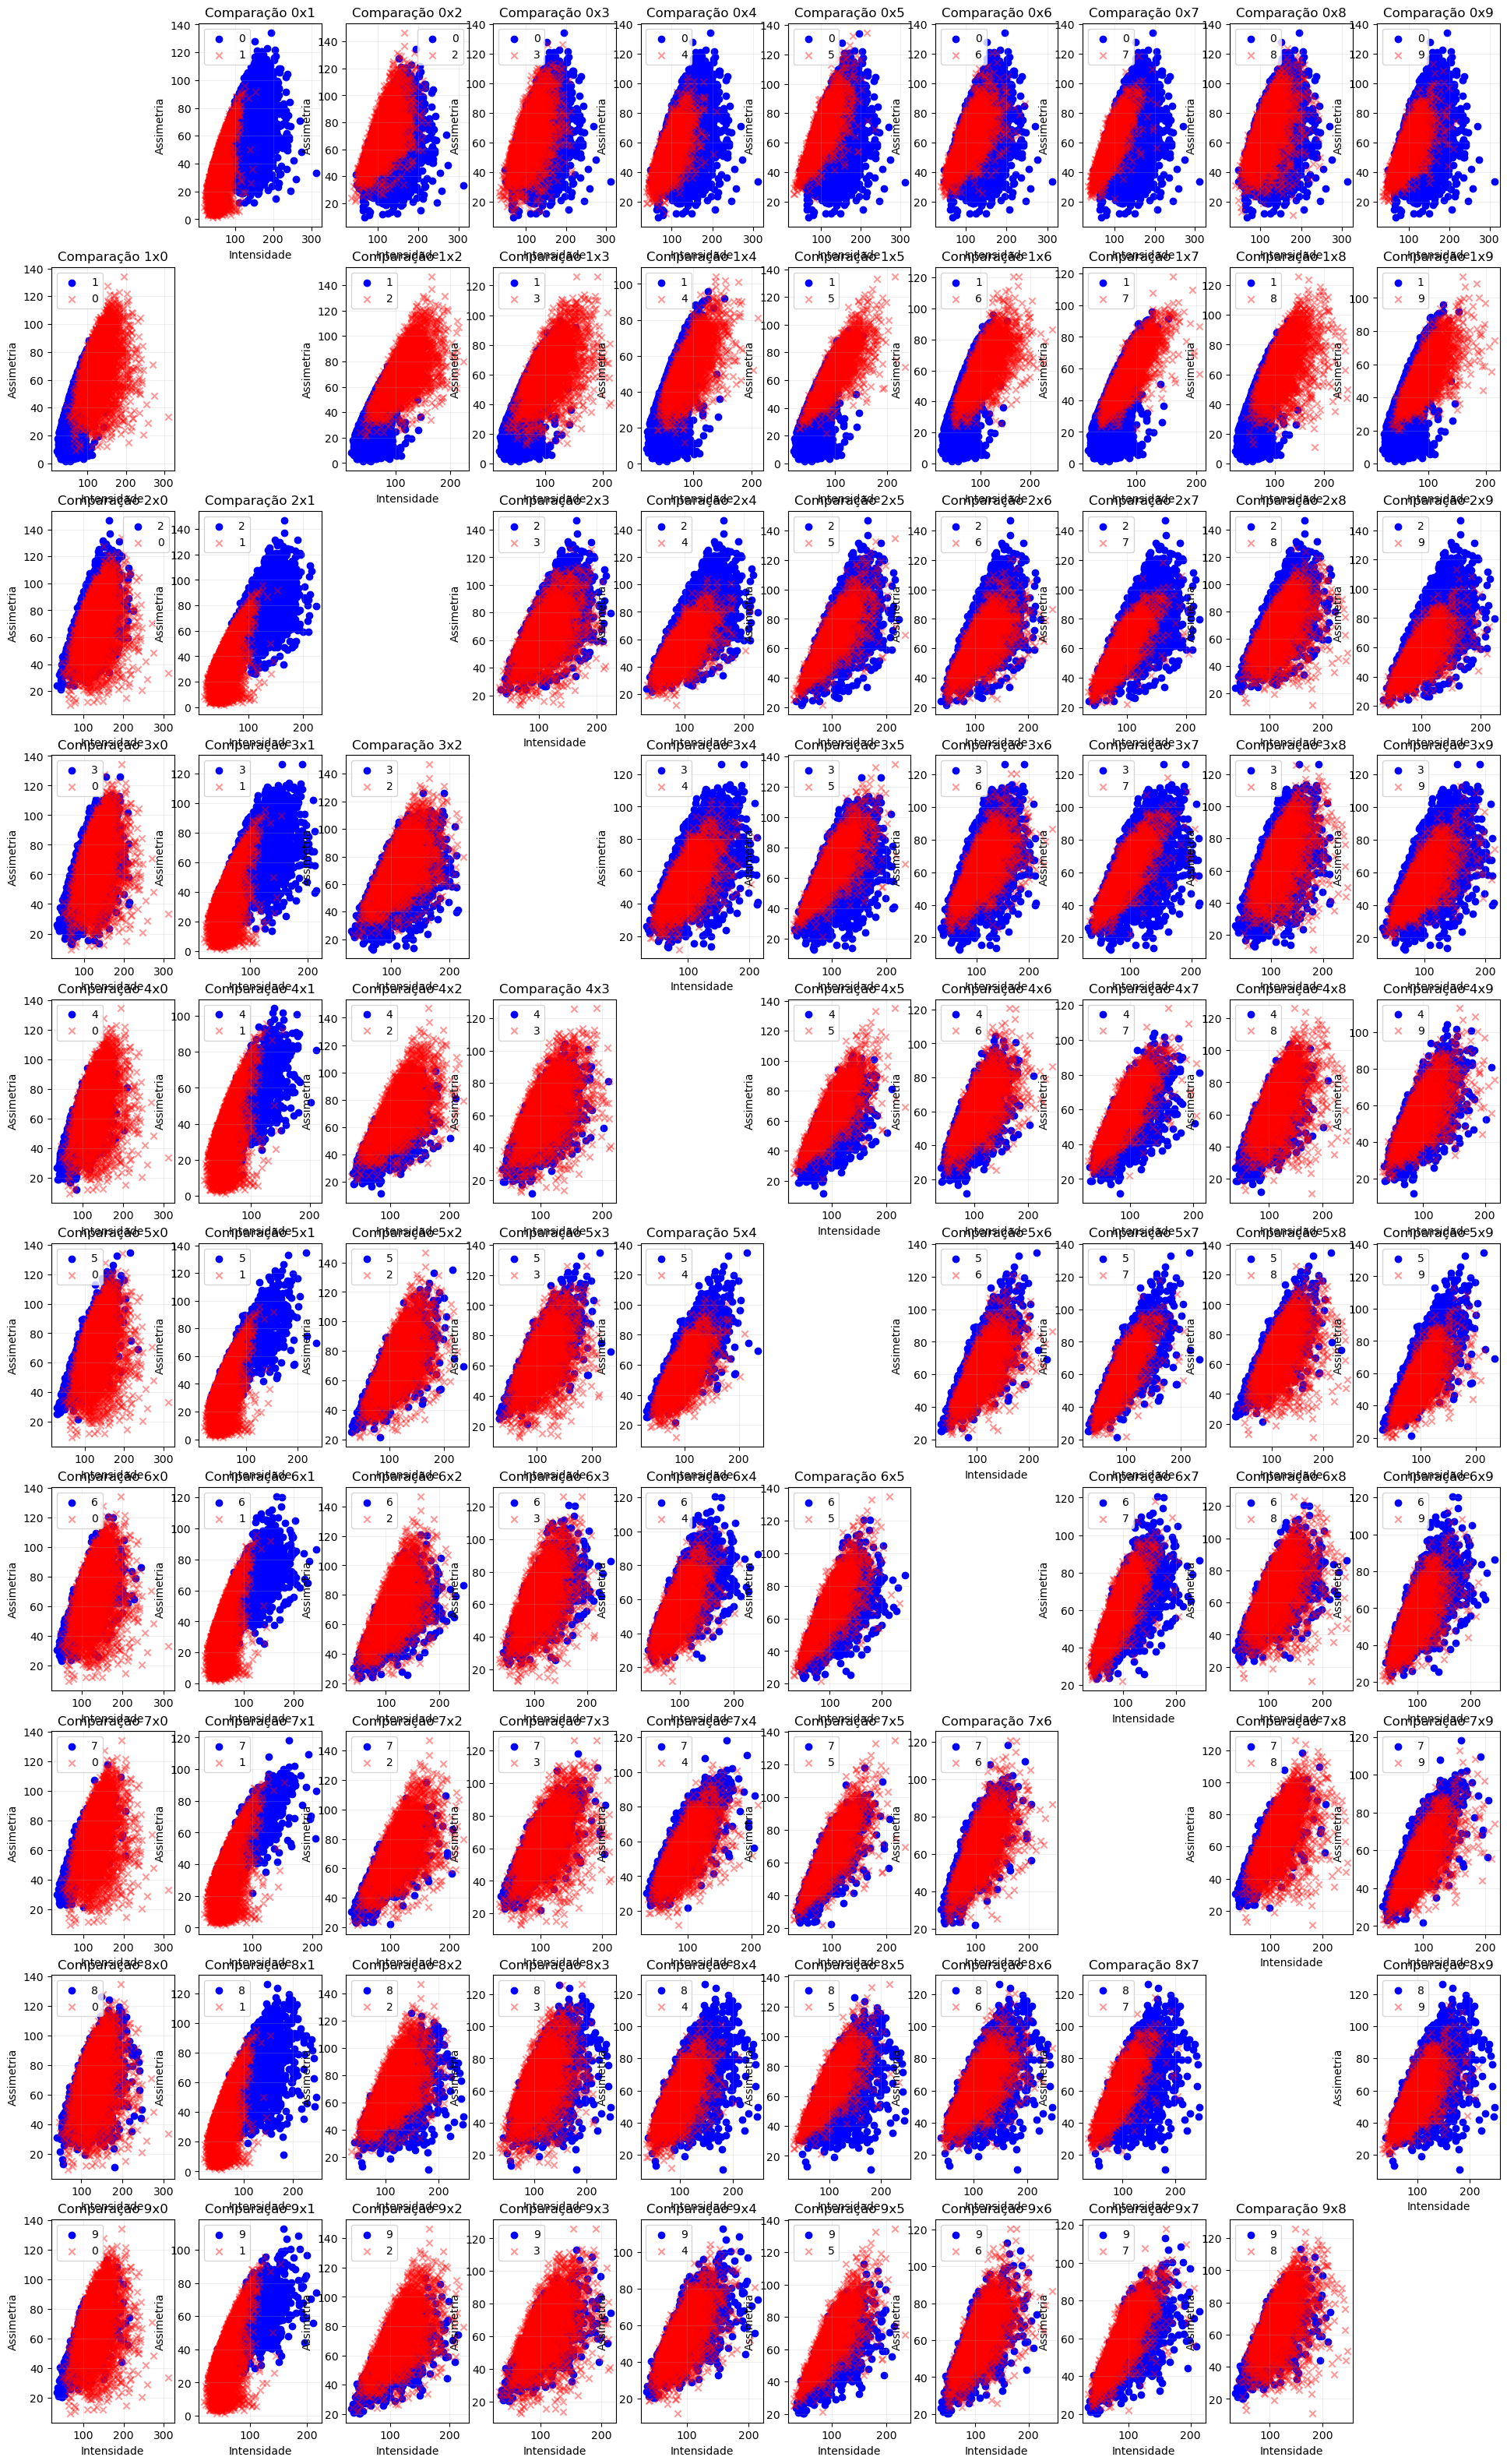

In [20]:
M=10

plt.figure(figsize = ((24, 40)))

for i in range(M):
    for j in range(M):
        if (i != j):
            plt.subplot(M, M, i*M + j+1)
            plot_2digits(digits[i], digits[j])

plt.show()

## CLASSIFICAÇÃO DOS DÍGITOS 1X5

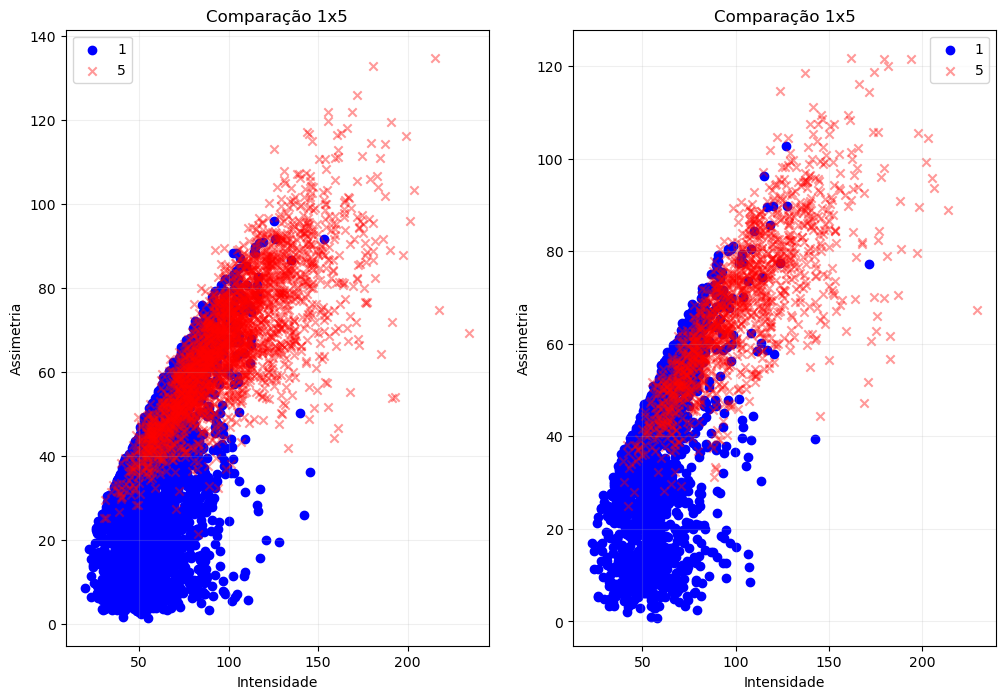

In [21]:
train_1x5 = select_digits(1, 5, new_data)
test_1x5 = select_digits(1, 5, new_data_test)

data_1, data_5 = cat_diff(1, 5, train_1x5)
data_1_test, data_5_test = cat_diff(1, 5, test_1x5)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plot_2digits(data_1, data_5)
plt.subplot(1, 2, 2)
plot_2digits(data_1_test, data_5_test)

In [22]:
# Preparando os dados

train_1x5[train_1x5[:, 2] == 5, 2] = -1
test_1x5[test_1x5[:, 2] == 5, 2] = -1

train_1x5

array([[ 65.29019608,  55.36862745,   1.        ],
       [ 52.64705882,   7.10980392,   1.        ],
       [ 48.41176471,  24.10588235,   1.        ],
       ...,
       [146.5254902 ,  73.58431373,  -1.        ],
       [113.34901961,  69.78039216,  -1.        ],
       [121.03529412,  69.82745098,  -1.        ]])

### Treinando os três classificadores:

Perceptron:

In [23]:
pla = PocketPLA()

pla.fit(train_1x5[:, :-1], train_1x5[:, 2], iter_max=500)

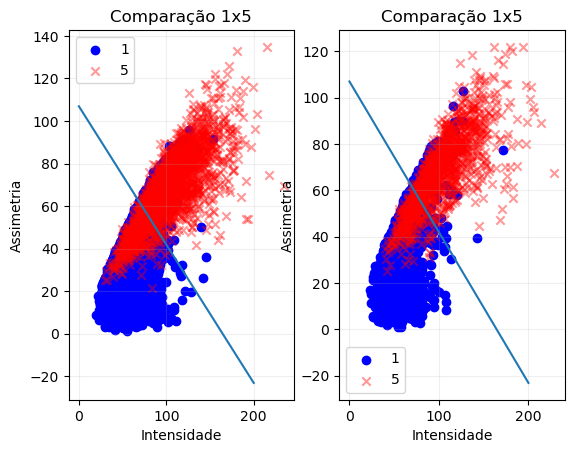

In [24]:
plt.subplot(1, 2, 1)
plot_2digits(data_1, data_5)
plt.plot([0, 200], [pla.eval(x) for x in (0, 200)])

plt.subplot(1, 2, 2)
plot_2digits(data_1_test, data_5_test)
plt.plot([0, 200], [pla.eval(x) for x in (0, 200)]);

Regressão linear:

In [25]:
lin_reg = LinearRegression()

lin_reg.fit(train_1x5[:, :-1], train_1x5[:, 2])

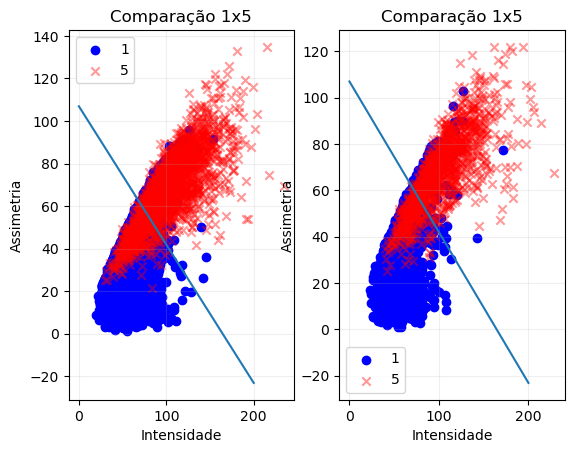

In [26]:
plt.subplot(1, 2, 1)
plot_2digits(data_1, data_5)
plt.plot([0, 200], [lin_reg.eval(x) for x in (0, 200)])

plt.subplot(1, 2, 2)
plot_2digits(data_1_test, data_5_test)
plt.plot([0, 200], [lin_reg.eval(x) for x in (0, 200)]);

Regressão logística:

In [27]:
log_reg = LogisticRegression()

log_reg.fit(train_1x5[:, :-1], train_1x5[:, 2], batch_size=50, tmax=30000)

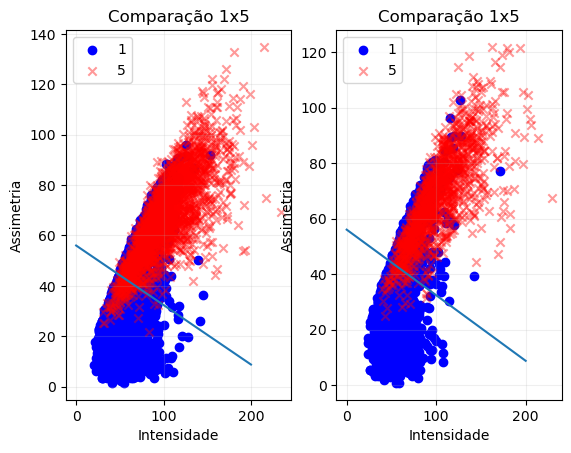

In [28]:
plt.subplot(1, 2, 1)
plot_2digits(data_1, data_5)
plt.plot([0, 200], [log_reg.eval(x) for x in (0, 200)])

plt.subplot(1, 2, 2)
plot_2digits(data_1_test, data_5_test)
plt.plot([0, 200], [log_reg.eval(x) for x in (0, 200)]);

### Criar método de predição do valor do dígito:

In [29]:
# Definindo um classificador pela composição dos três modelos lineares

class Classifier1x5:
    def fit(self, X, Y, tmax_pla=1000, tmax_log=1000, batch_size=None):
        self._pla = PocketPLA()
        self._lin_reg = LinearRegression()
        self._log_reg = LogisticRegression()

        self._pla.fit(X, Y, iter_max=tmax_pla)
        self._lin_reg.fit(X, Y)
        self._log_reg.fit(X, Y, batch_size=batch_size, tmax=tmax_log)  
                
    def predict(self, x, method=0):
        if (method==0):
            pred = self._pla.predict(x)
        elif (method==1):
            pred = self._lin_reg.classifier(x)
        else:
            pred = self._log_reg.predict(x)
            
        return 1 if pred == 1 else 5

    def eval(self, x1, method=0):  # method that gets the value of x2
        if (method==0):
            return self._pla.eval(x)
        elif (method==1):
            return self._lin_reg.eval(x)
        else:
            return self._log_reg.eval(x)
        
    def predict_lr(self, x):
        return self._lin_reg.predict(x)
    
    def predict_prob(self, x):
        return self._log_reg.predict_prob(x)
    
    def score(self, X, Y, method=0):
        if (method==0):
            return self._pla.score(X, Y)
        elif (method==1):
            return self._lin_reg.score(X, Y)
        else:
            return self._log_reg.score(X, Y)

In [30]:
# Testando o classificador

classifier = Classifier1x5()
classifier.fit(train_1x5[:, :-1], train_1x5[:, 2], tmax_pla=500, tmax_log=30000, batch_size=50)

In [31]:
# Testando os três modelos lineares

print("Testando para um exemplo do dígito 1.")
print("Utilizando o PLA:", classifier.predict(data_1_test[1][:2]))
print("Utilizando a regressão linear:", classifier.predict(data_1_test[1][:2], method=1))
print("Utilizando a regressão logística:", classifier.predict(data_1_test[1][:2], method=2))

print()

print("Testando para um exemplo do dígito 5.")
print("Utilizando o PLA:", classifier.predict(data_5_test[1][:2]))
print("Utilizando a regressão linear:", classifier.predict(data_5_test[1][:2], method=1))
print("Utilizando a regressão logística:", classifier.predict(data_5_test[1][:2], method=2))

Testando para um exemplo do dígito 1.
Utilizando o PLA: 1
Utilizando a regressão linear: 1
Utilizando a regressão logística: 5

Testando para um exemplo do dígito 5.
Utilizando o PLA: 5
Utilizando a regressão linear: 5
Utilizando a regressão logística: 5


### Testar os três classificadores:

Gerar a matriz de confusão e os relatórios de eficácia de classificação de cada
classificador.

In [32]:
y_pred = [classifier._pla.predict(x)
          for x in test_1x5[:, :2]]

print("Analisando os resultados obtidos com o PLA:")

print()
print(f"Acurácia na amostra = {classifier.score(train_1x5[:, :2], train_1x5[:, 2], method=0)*100:.2f}%")
print(f"Acurácia fora da amostra = {classifier.score(test_1x5[:, :2], test_1x5[:, 2], method=0)*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(test_1x5[:, 2], y_pred),
                   index=['f(x)=-1', 'f(x)=+1'],
                   columns=['h(x)=-1', 'h(x)=+1']))

print()
print(classification_report(test_1x5[:, 2], y_pred))

Analisando os resultados obtidos com o PLA:

Acurácia na amostra = 83.56%
Acurácia fora da amostra = 83.24%

         h(x)=-1  h(x)=+1
f(x)=-1     1005      319
f(x)=+1      159     1369

              precision    recall  f1-score   support

        -1.0       0.86      0.76      0.81      1324
         1.0       0.81      0.90      0.85      1528

    accuracy                           0.83      2852
   macro avg       0.84      0.83      0.83      2852
weighted avg       0.84      0.83      0.83      2852



In [33]:
y_pred = [classifier._lin_reg.classifier(x)
          for x in test_1x5[:, :2]]

print("Analisando os resultados obtidos com a regressão linear:")

print()
print(f"Acurácia na amostra = {classifier.score(train_1x5[:, :2], train_1x5[:, 2], method=1)*100:.2f}%")
print(f"Acurácia fora da amostra = {classifier.score(test_1x5[:, :2], test_1x5[:, 2], method=1)*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(test_1x5[:, 2], y_pred),
                   index=['f(x)=-1', 'f(x)=+1'],
                   columns=['h(x)=-1', 'h(x)=+1']))

print()
print(classification_report(test_1x5[:, 2], y_pred))

Analisando os resultados obtidos com a regressão linear:

Acurácia na amostra = 83.56%
Acurácia fora da amostra = 83.24%

         h(x)=-1  h(x)=+1
f(x)=-1     1005      319
f(x)=+1      159     1369

              precision    recall  f1-score   support

        -1.0       0.86      0.76      0.81      1324
         1.0       0.81      0.90      0.85      1528

    accuracy                           0.83      2852
   macro avg       0.84      0.83      0.83      2852
weighted avg       0.84      0.83      0.83      2852



In [34]:
y_pred = [classifier._log_reg.predict(x)
          for x in test_1x5[:, :2]]

print("Analisando os resultados obtidos com a regressão logística:")

print()
print(f"Acurácia na amostra = {classifier.score(train_1x5[:, :2], train_1x5[:, 2], method=2)*100:.2f}%")
print(f"Acurácia fora da amostra = {classifier.score(test_1x5[:, :2], test_1x5[:, 2], method=2)*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(test_1x5[:, 2], y_pred),
                   index=['f(x)=-1', 'f(x)=+1'],
                   columns=['h(x)=-1', 'h(x)=+1']))

print()
print(classification_report(test_1x5[:, 2], y_pred))

Analisando os resultados obtidos com a regressão logística:

Acurácia na amostra = 66.06%
Acurácia fora da amostra = 68.48%

         h(x)=-1  h(x)=+1
f(x)=-1     1319        5
f(x)=+1      894      634

              precision    recall  f1-score   support

        -1.0       0.60      1.00      0.75      1324
         1.0       0.99      0.41      0.59      1528

    accuracy                           0.68      2852
   macro avg       0.79      0.71      0.67      2852
weighted avg       0.81      0.68      0.66      2852



## CLASSIFICADOR DE DÍGITOS COMPLETO

In [35]:
# Separando os dados em features e labels

features, labels = new_data[:, :2], new_data[:, 2]
features_test, labels_test = new_data_test[:, :2], new_data_test[:, 2]

Perceptron:

In [55]:
class PLAClassifierDigits:
    def __init__(self):
        self._pla = [None] * 9
        
    def __getitem__(self, d):
        return self._pla[d]
        
    def fit(self, X, Y, iter_max=1000):
        digits = [X[Y == i]
                  for i in range(10)]

        for i in range(9):
            _X = np.vstack(digits[i:])
            _Y = np.concatenate((np.ones(len(digits[i])), np.ones(len(_X) - len(digits[i]))*-1))
            
            self._pla[i] = PocketPLA()
            self._pla[i].fit(_X, _Y, iter_max=iter_max)
        
    def predict(self, x):
        for i in range(9):
            if (self._pla[i].predict(x) == 1):
                return i
        
        return 9
            
    def score(self, X, Y):
        success = 0
        
        for x, y in zip(X, Y):
            if self.predict(x) == y:
                success += 1
            
        return success / len(Y)

In [59]:
classifier = PLAClassifierDigits()

classifier.fit(features, labels, iter_max=50)

In [60]:
y_pred = [classifier.predict(x)
          for x in features_test]

print("Analisando os resultados obtidos com o PocketPLA:")

print()
print(f"Acurácia na amostra = {classifier.score(features, labels)*100:.2f}%")
print(f"Acurácia fora da amostra = {classifier.score(features_test, labels_test)*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(labels_test, y_pred)))

print()
print(classification_report(labels_test, y_pred, zero_division=0))

Analisando os resultados obtidos com o PocketPLA:

Acurácia na amostra = 16.46%
Acurácia fora da amostra = 16.00%

    0    1  2  3  4   5  6    7    8    9
0  26   15  0  0  0   0  0   41  951  353
1   0  156  0  0  0   0  0  708   25  639
2   3    0  0  0  0  15  0  219  814  325
3   3    1  0  0  0   1  0  154  780  586
4   0    0  0  0  0   0  0  127  381  884
5   1    0  0  0  0   2  0  300  619  402
6   0    0  0  0  0   0  0   90  697  633
7   0    0  0  0  0   0  0  342  458  720
8  10    1  0  0  0   0  0   62  849  451
9   0    0  0  0  0   0  0   93  389  901

              precision    recall  f1-score   support

         0.0       0.60      0.02      0.04      1386
         1.0       0.90      0.10      0.18      1528
         2.0       0.00      0.00      0.00      1376
         3.0       0.00      0.00      0.00      1525
         4.0       0.00      0.00      0.00      1392
         5.0       0.11      0.00      0.00      1324
         6.0       0.00      0.00      0.00

Regressão Linear:

In [39]:
class LinRClassifierDigits:
    def __init__(self):
        self._lin_reg = [None] * 9
        
    def __getitem__(self, d):
        return self._lin_reg[d]
        
    def fit(self, X, Y):
        digits = [X[Y == i]
                  for i in range(10)]

        for i in range(9):
            _X = np.vstack(digits[i:])
            _Y = np.concatenate((np.ones(len(digits[i])), np.ones(len(_X) - len(digits[i]))*-1))
            
            self._lin_reg[i] = LinearRegression()
            self._lin_reg[i].fit(_X, _Y)
        
    def predict(self, x):
        for i in range(9):
            if (self._lin_reg[i].classifier(x) == 1):
                return i
        
        return 9
            
    def score(self, X, Y):
        success = 0
        
        for x, y in zip(X, Y):
            if self.predict(x) == y:
                success += 1
            
        return success / len(Y)

In [61]:
classifier = LinRClassifierDigits()

classifier.fit(features, labels)

In [62]:
y_pred = [classifier.predict(x)
          for x in features_test]

print("Analisando os resultados obtidos com a regressão linear:")

print()
print(f"Acurácia na amostra = {classifier.score(features, labels)*100:.2f}%")
print(f"Acurácia fora da amostra = {classifier.score(features_test, labels_test)*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(labels_test, y_pred)))

print()
print(classification_report(labels_test, y_pred, zero_division=0))

Analisando os resultados obtidos com a regressão linear:

Acurácia na amostra = 16.25%
Acurácia fora da amostra = 15.74%

    0    1  2  3  4   5  6    7    8    9
0  26    0  0  0  0   0  0   41  952  367
1   0  119  0  0  0   0  0  698   25  686
2   3    0  0  0  0  15  0  219  814  325
3   3    1  0  0  0   1  0  154  780  586
4   0    1  0  0  0   0  0  126  381  884
5   1    0  0  0  0   2  0  300  619  402
6   0    1  0  0  0   0  0   89  697  633
7   0    0  0  0  0   0  0  342  458  720
8  10    0  0  0  0   0  0   62  849  452
9   0    0  0  0  0   0  0   93  389  901

              precision    recall  f1-score   support

         0.0       0.60      0.02      0.04      1386
         1.0       0.98      0.08      0.14      1528
         2.0       0.00      0.00      0.00      1376
         3.0       0.00      0.00      0.00      1525
         4.0       0.00      0.00      0.00      1392
         5.0       0.11      0.00      0.00      1324
         6.0       0.00      0.00   

Regressão Logística:

In [63]:
class LogRClassifierDigits:
    def __init__(self):
        self._log_reg = [None] * 9
        
    def __getitem__(self, d):
        return self._log_reg[d]
        
    def fit(self, X, Y, batch_size=50, tmax=10000):
        digits = [X[Y == i]
                  for i in range(10)]

        for i in range(9):
            _X = np.vstack(digits[i:])
            _Y = np.concatenate((np.ones(len(digits[i])), np.ones(len(_X) - len(digits[i]))*-1))
            
            self._log_reg[i] = LogisticRegression()
            self._log_reg[i].fit(_X, _Y, batch_size=batch_size, tmax=tmax)
        
    def predict(self, x):
        for i in range(9):
            if (self._log_reg[i].predict(x) == 1):
                return i
        
        return 9
            
    def score(self, X, Y):
        success = 0
        
        for x, y in zip(X, Y):
            if self.predict(x) == y:
                success += 1
            
        return success / len(Y)

In [64]:
classifier = LogRClassifierDigits()

classifier.fit(features, labels)

In [65]:
y_pred = [classifier.predict(x)
          for x in features_test]

print("Analisando os resultados obtidos com a regressão logística:")

print()
print(f"Acurácia na amostra = {classifier.score(features, labels)*100:.2f}%")
print(f"Acurácia fora da amostra = {classifier.score(features_test, labels_test)*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(labels_test, y_pred)))

print()
print(classification_report(labels_test, y_pred, zero_division=0))

Analisando os resultados obtidos com a regressão logística:

Acurácia na amostra = 10.44%
Acurácia fora da amostra = 10.03%

     0  1  2  3  4  5  6    7  8     9
0   28  0  0  0  0  0  0    3  0  1355
1  119  0  0  0  0  0  0  164  0  1245
2    0  0  0  0  0  0  0   40  0  1336
3    3  0  0  0  0  0  0   37  0  1485
4    0  0  0  0  0  0  0    3  0  1389
5    0  0  0  0  0  0  0   31  0  1293
6    0  0  0  0  0  0  0    3  0  1417
7    0  0  0  0  0  0  0   19  0  1501
8    6  0  0  0  0  0  0    0  0  1367
9    0  0  0  0  0  0  0    3  0  1380

              precision    recall  f1-score   support

         0.0       0.18      0.02      0.04      1386
         1.0       0.00      0.00      0.00      1528
         2.0       0.00      0.00      0.00      1376
         3.0       0.00      0.00      0.00      1525
         4.0       0.00      0.00      0.00      1392
         5.0       0.00      0.00      0.00      1324
         6.0       0.00      0.00      0.00      1420
         7.0

### Analisando o resultado:

Treinando um classificador com regressão linear para o 0 contra todos os dígitos podemos obter a intuição do problema nos métodos acima:

In [45]:
# Obtendo os dados de treino

data_0 = new_data[new_data[:, 2] == 0]
data_all = new_data[new_data[:, 2] != 0]

data_0[:, 2] = 1
data_all[:, 2] = -1

data_0xAll = np.concatenate((data_0, data_all))

# Obtendo os dados para test

data_0_test = new_data_test[new_data_test[:, 2] == 0]
data_all_test = new_data_test[new_data_test[:, 2] != 0]

data_0_test[:, 2] = 1
data_all_test[:, 2] = -1

data_0xAll_test = np.concatenate((data_0_test, data_all_test))

In [46]:
classifier_0xAll = LinearRegression()

classifier_0xAll.fit(data_0xAll[:, :2], data_0xAll[:, 2])

In [47]:
y_pred = [classifier_0xAll.classifier(x)
          for x in data_0xAll_test[:, :2]]

print("Analisando os resultados obtidos:")

print()
print(f"Acurácia na amostra = {classifier_0xAll.score(data_0xAll[:, :2], data_0xAll[:, 2])*100:.2f}%")
print(f"Acurácia fora da amostra = {classifier_0xAll.score(data_0xAll_test[:, :2], data_0xAll_test[:, 2])*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(data_0xAll_test[:, 2], y_pred),
                   index=['All', 0], columns=['All', 0]))

print()
print(classification_report(data_0xAll_test[:, 2], y_pred, zero_division=0))

Analisando os resultados obtidos:

Acurácia na amostra = 90.23%
Acurácia fora da amostra = 90.32%

       All   0
All  12824  17
0     1360  26

              precision    recall  f1-score   support

        -1.0       0.90      1.00      0.95     12841
         1.0       0.60      0.02      0.04      1386

    accuracy                           0.90     14227
   macro avg       0.75      0.51      0.49     14227
weighted avg       0.87      0.90      0.86     14227



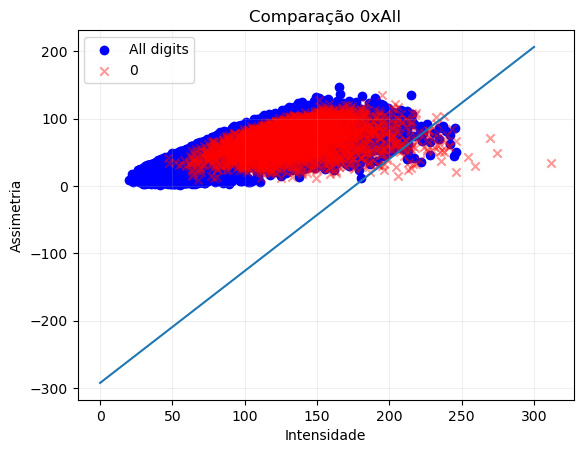

In [48]:
# Verificando os resultados de forma gráfica

plt.grid(alpha= 0.2)

plt.scatter(data_all[:, 0], data_all[:, 1], c='blue', label='All digits')
plt.scatter(data_0[:, 0], data_0[:,1], c='red', alpha=0.4, marker='x', label='0')

plt.title(f'Comparação 0xAll')
plt.xlabel('Intensidade')
plt.ylabel('Assimetria')

plt.legend()
plt.plot([0, 300], [classifier_0xAll.eval(x) for x in (0, 300)])

plt.show()

## DISCUSSÃO

In [49]:
%matplotlib notebook

Testando um classificador de 1x5 levando em consideração a intensidade e as simetrias vertical e horizontal dos digitos:

In [50]:
data_1 = new_data_3dim[new_data_3dim[:, 3] == 1]
data_5 = new_data_3dim[new_data_3dim[:, 3] == 5]
data_5[:, 3] = -1

train_1x5 = np.concatenate((data_1, data_5))

data_1_test = new_data_3dim_test[new_data_3dim_test[:, 3] == 1]
data_5_test = new_data_3dim_test[new_data_3dim_test[:, 3] == 5]
data_5_test[:, 3] = -1

test_1x5 = np.concatenate((data_1_test, data_5_test))

In [51]:
# Utilizando a regressão linear

lin_reg = LinearRegression()

lin_reg.fit(train_1x5[:, :3], train_1x5[:, 3])

In [52]:
y_pred = [lin_reg.classifier(x)
          for x in test_1x5[:, :3]]

print("Analisando os resultados obtidos com a regressão linear:")

print()
print(f"Acurácia na amostra = {lin_reg.score(train_1x5[:, :3], train_1x5[:, 3])*100:.2f}%")
print(f"Acurácia fora da amostra = {lin_reg.score(test_1x5[:, :3], test_1x5[:, 3])*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(test_1x5[:, 3], y_pred),
                   index=['f(x)=-1', 'f(x)=+1'],
                   columns=['h(x)=-1', 'h(x)=+1']))

print()
print(classification_report(test_1x5[:, 3], y_pred))

Analisando os resultados obtidos com a regressão linear:

Acurácia na amostra = 83.93%
Acurácia fora da amostra = 83.10%

         h(x)=-1  h(x)=+1
f(x)=-1     1182      142
f(x)=+1      340     1188

              precision    recall  f1-score   support

        -1.0       0.78      0.89      0.83      1324
         1.0       0.89      0.78      0.83      1528

    accuracy                           0.83      2852
   macro avg       0.83      0.84      0.83      2852
weighted avg       0.84      0.83      0.83      2852



<IPython.core.display.Javascript object>


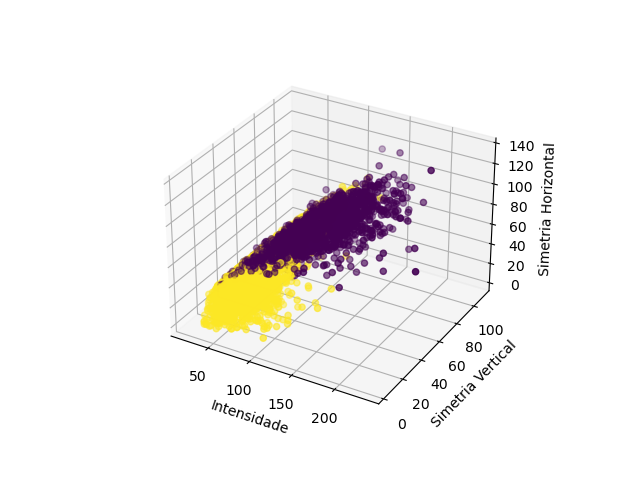

In [53]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(train_1x5[:, 0], train_1x5[:, 1], train_1x5[:, 2], c=train_1x5[:, 3])

ax.set_xlabel('Intensidade')
ax.set_ylabel('Simetria Vertical')
ax.set_zlabel('Simetria Horizontal')

plt.show()

<IPython.core.display.Javascript object>


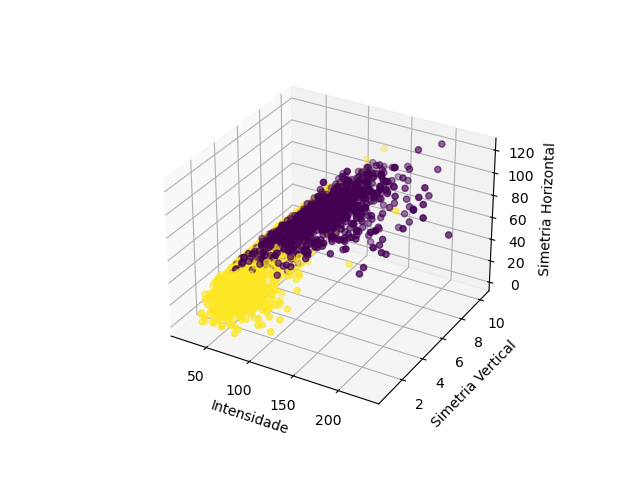

In [54]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(test_1x5[:, 0], test_1x5[:, 1], test_1x5[:, 2], c=test_1x5[:, 3])

ax.set_xlabel('Intensidade')
ax.set_ylabel('Simetria Vertical')
ax.set_zlabel('Simetria Horizontal')

plt.show()